#### load dependencies

In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D,SpatialDropout1D,GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from keras.datasets import imdb
%matplotlib inline

C:\Users\Munna chowhan\Anaconda3\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### set hyperparameters

In [2]:
output_dir = "model_output/CNN/"

epochs = 6
batch_size = 128

#embedding layer:
n_dims = 64
max_review_length = 400
# skip top 50 words to skip common words(stopwords are not removed so have to do this)
n_words_to_skip = 50
n_unique_words = 5000
#while padding if the review is < 100 words pad it at the beginning of the review.
#while truncating if the review is > 100 cut the review at the beginning
pad_type = trunc_type = "pre"
dropout_embed = 0.2
#conv layer:
n_conv = 256
k_conv = 3


#dense_layer:
n_dense = 256
dropout = 0.2

In [3]:
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=n_unique_words)

In [4]:
x_train = pad_sequences(x_train,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)
x_test = pad_sequences(x_test,maxlen=max_review_length,padding=pad_type,truncating=trunc_type,value=0)

In [5]:
model = Sequential()

In [6]:
model.add(Embedding(n_unique_words,n_dims,input_length=max_review_length))
model.add(SpatialDropout1D(dropout_embed))
model.add(Conv1D(n_conv,k_conv,activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense,activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(1, activation="sigmoid"))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [8]:
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=["accuracy"])

### save the model weights for every epoch

In [9]:
modelcheckpoint  = ModelCheckpoint(filepath=output_dir +"weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

###  train the model

In [10]:
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test),verbose=1, callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 257s 10ms/step - loss: 0.4898 - acc: 0.7451 - val_loss: 0.2993 - val_acc: 0.8733
Epoch 2/6
25000/25000 [==============================] - 241s 10ms/step - loss: 0.2544 - acc: 0.8960 - val_loss: 0.2655 - val_acc: 0.8876
Epoch 3/6
25000/25000 [==============================] - 256s 10ms/step - loss: 0.1722 - acc: 0.9347 - val_loss: 0.2581 - val_acc: 0.8948
Epoch 4/6
25000/25000 [==============================] - 245s 10ms/step - loss: 0.1157 - acc: 0.9600 - val_loss: 0.2833 - val_acc: 0.8911
Epoch 5/6
25000/25000 [==============================] - 249s 10ms/step - loss: 0.0722 - acc: 0.9770 - val_loss: 0.3266 - val_acc: 0.8900
Epoch 6/6
25000/25000 [==============================] - 256s 10ms/step - loss: 0.0453 - acc: 0.9856 - val_loss: 0.3942 - val_acc: 0.8852


### load the epoch with highest validation accuracy

In [11]:
model.load_weights(filepath=output_dir+"/weights.02.hdf5")

### make predictions on test set

In [12]:
y_pred = model.predict_proba(x_test)

In [13]:
y_pred[0]

array([0.01882129], dtype=float32)

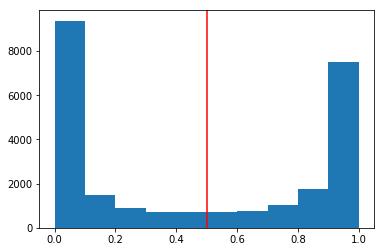

In [14]:
plt.hist(y_pred)
_ = plt.axvline(x = 0.5, color="red")

In [15]:
auc = roc_auc_score(y_test,y_pred)*100.0

In [16]:
auc

95.92739551999999

In [17]:
predicted_sentiment = []
for i in y_pred:
    predicted_sentiment.append(i[0])

In [18]:
df = pd.DataFrame(list(zip(predicted_sentiment,y_test)),columns=["predicted","real"])

In [19]:
df.head()

,predicted,real
0,0.018821,0
1,0.986517,1
2,0.920314,1
3,0.379073,0
4,0.930178,1
